# Computational Linear Algebra for Large Scale Problems - HW_PCA

| Student Name         | Student ID | Email                    |
|----------------------|------------|--------------------------|
| Mohammadreza Mohammadi | 288654     | s288654@studenti.polito.it |
| Ali Ghasemi          | 289223     | s289223@studenti.polito.it |


# Introduction
In this homework, we are going to use Principal Component Analysis to apply dimentionality reduction on a dataset and then use the reduced dataset to cluster the data points using K-means algorithm. 

The dataset is a preprocessed and cleansed version of a dataset extracted from bikez.com on April 30th 2022, using a custom scraper in order to enrich an existing used motorcycle dataset for a hackathon competition.


# Library Imports and Configuration

In the following cells, first we import the required libraries and then we configure the notebook to display the plots inline. In addition, we set the random seed to the minimum of the student IDs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
import re
from mpl_toolkits.mplot3d import Axes3D

# disable warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

# set plot style
plt.style.use('seaborn')

# set the number of rows to display (optimal for pdf export)
pd.set_option('display.max_rows', 20)

In [2]:
rs = min(289223,288654) #since there are two students
np.random.seed(rs)

# Excercises

## Exercise 1

### Load the dataset

First we load the dataset from the csv file and then we print the general information about the dataset.

In [3]:
dataset_path = 'cla4lsp22_bikez_curated.csv'
df_tot = pd.read_csv(dataset_path)

**Shape of the dataset**

In [4]:
print(f"Shape of the dataset: {df_tot.shape}")

Shape of the dataset: (38472, 27)


**Columns**

In [5]:
df_tot.columns

Index(['Brand', 'Model', 'Year', 'Category', 'Rating', 'Displacement (ccm)',
       'Power (hp)', 'Torque (Nm)', 'Engine cylinder', 'Engine stroke',
       'Gearbox', 'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)',
       'Fuel control', 'Cooling system', 'Transmission type',
       'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)', 'Fuel system',
       'Front brakes', 'Rear brakes', 'Front tire', 'Rear tire',
       'Front suspension', 'Rear suspension'],
      dtype='object')

### Prepare the dataset
According to what we have been asked in the homework description, we take the following steps to prepare the dataset:

1) using `random.randint` function, we generate a random integer number between 0 and 2 (inclusive) and then we use this number to filter the rows of the dataset. Particularly, we keep the rows for which the remainder of the division of the year by 3 is equal to the generated random number.

In [6]:
workdf = df_tot[df_tot["Year"] % 3 == np.random.randint(0, 2)].copy()

In [7]:
print(f"Shape of the dataset after filtering: {workdf.shape}")

Shape of the dataset after filtering: (12266, 27)


2) The dataset columns are divided into two groups: label and features. The label columns are `Brand`, `Model`, `Year`, `Category` and `Rating`. The rest of the columns are considered as features.

In [8]:
# creating sub-dataframe for work

labels_list = ['Brand', 'Model', 'Year', 'Category', 'Rating']
labels = workdf[labels_list]
features = workdf.drop(labels_list, axis=1)

3) Then among a predefined list `features_to_drop`, we randomly choose two feature columns and drop them from the dataset.

In [9]:
# Define the list of features to drop
features_to_drop = ['Front brakes', 'Rear brakes', 'Front tire',
                     'Rear tire', 'Front suspension', 'Rear suspension']

# randomly dropping two columns from features
dropped_columns = np.random.choice(features_to_drop, size=2,
                                    replace=False)
features.drop(dropped_columns, axis=1, inplace=True)

# show the features that have been removes
print(f"Removed features: {dropped_columns}")

Removed features: ['Rear suspension' 'Rear brakes']


4. Cleaning the dataset from missing values.
This part has been one of the most critical and time consuming parts of the homework as this dataset contains a rather considerable amount of missing values. To clean the dataset, following steps have been taken: <br>
    a) In this part, we are going to handle the missing values.
    Missing values in the numerical columnns can be recongnized easily by Pandas library whereas missing values in the categorical columns are represented by different forms of the text: `Not Given/Unknown` or `not given/unknown`.
    That is why we first replace all the `Not Given/Unknown` values in any form with the `np.nan` value.
    Then we try to figure out statistical information about the missing values in the dataset.
    It is worth mentioning that the transformation of missing values for categorical columns is not done on the working data frame. It is done here only for the purpose of statistical analysis. <br>

In [10]:
pd.options.display.float_format = '{:.4f}'.format

# missing values for categorical variables is in the following format missing_value_pattern = re.compile(r'^[Nn]ot\s[Gg]iven/[Uu]nknown$')
missing_value_pattern = re.compile(r'^[Nn]ot\s[Gg]iven/[Uu]nknown$')

# replace missing values with np.nan
features_missing_df = features.replace(missing_value_pattern, np.nan,
                                        inplace=False, regex=True)
# check missing values
missing_values = pd.DataFrame(features_missing_df.isnull().sum(),
                               columns=['Missing values'])

missing_values['Percentage'] = missing_values['Missing values'] / len(features_missing_df) * 100
# add type of variable
missing_values['Type'] = features_missing_df.dtypes
missing_values.sort_values(by='Percentage', ascending=False, inplace=True)
missing_values

,Missing values,Percentage,Type
Torque (Nm),7256,59.1554,float64
Fuel control,5438,44.3339,object
Dry weight (kg),5079,41.4071,float64
Seat height (mm),4755,38.7657,float64
Wheelbase (mm),4286,34.9421,float64
Front suspension,4016,32.7409,object
Power (hp),4000,32.6105,float64
Fuel system,3555,28.9826,object
Bore (mm),3230,26.3330,float64
Stroke (mm),3230,26.3330,float64


b) As could be seen in the above table, the number of missing values for `Torque (Nm)` column is very high. So we drop this column.

In [11]:
features.drop(['Torque (Nm)'], axis=1, inplace=True)

c) One other step that could be taken based on the above table is to drop the rows that have missing values in the `Displacement` column. This is because the number of missing values in this column is very low.

In [12]:
features.dropna(subset=['Displacement (ccm)'], axis=0, inplace=True)

In [13]:
# The categorical columns
categorical_cols_name_list = features.select_dtypes(include=['object']).columns.to_list()

#The numerical columns
numerical_cols_name_list = features.drop(categorical_cols_name_list,
                                          axis=1, inplace=False).columns.tolist()

print(f"Numerical columns: {numerical_cols_name_list}")
print(f"Categorical columns: {categorical_cols_name_list}")

Numerical columns: ['Displacement (ccm)', 'Power (hp)', 'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)', 'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)']
Categorical columns: ['Engine cylinder', 'Engine stroke', 'Gearbox', 'Fuel control', 'Cooling system', 'Transmission type', 'Fuel system', 'Front brakes', 'Front tire', 'Rear tire', 'Front suspension']


d) For better handling of missing values, we could exploit the correlation of the columns.

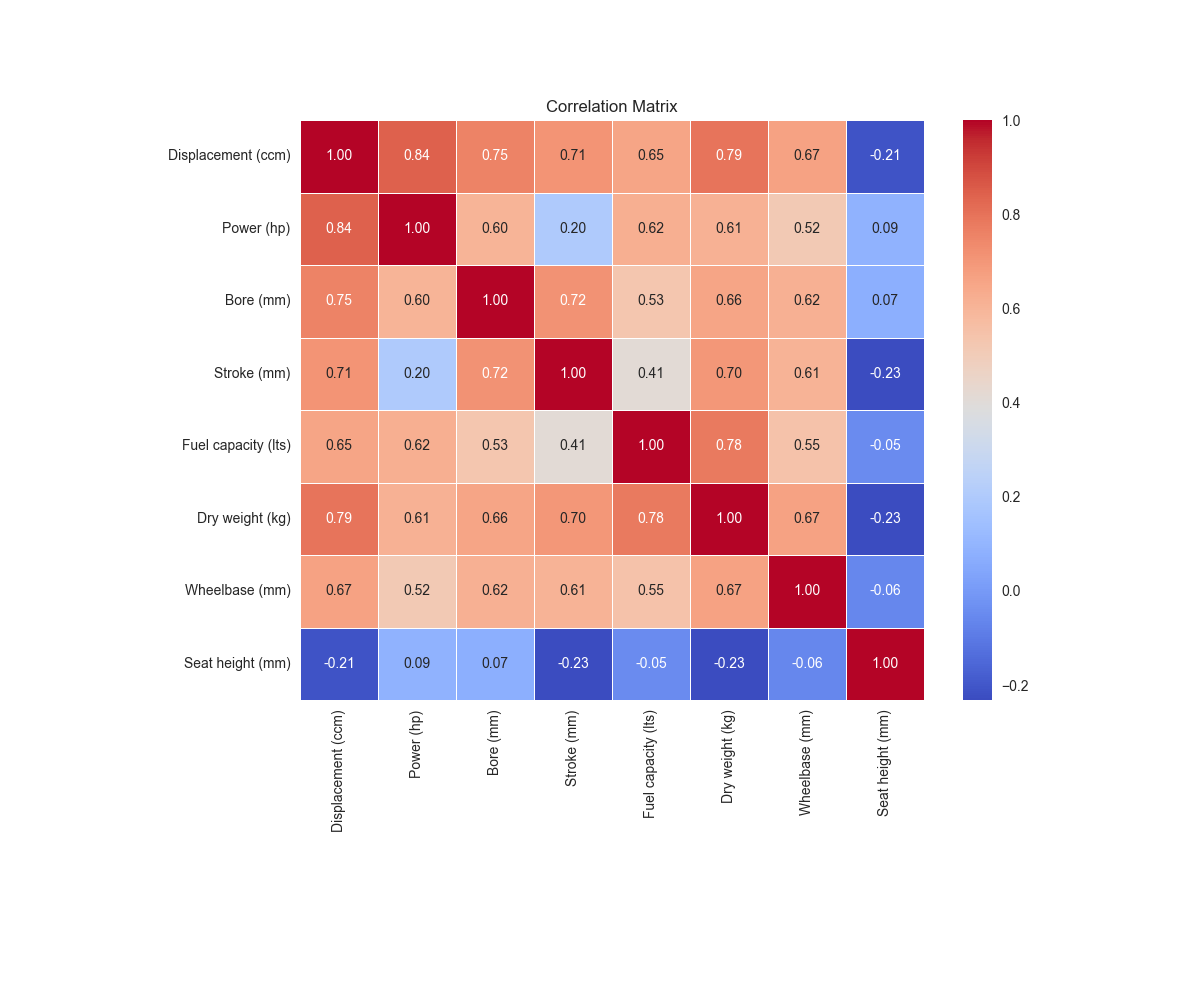

In [14]:
# Calculate the Pearson correlation for numerical_cols
correlation_matrix = features[numerical_cols_name_list].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True,
             cmap='coolwarm', fmt=".2f", linewidths=0.5)
# add left and bottom margin
plt.subplots_adjust(left=0.25, bottom=0.3)
plt.title('Correlation Matrix')
plt.show()

Looking at the correlation matrix, we can see that the `Displacement` column has a very high correlation with almost all of the other numerical columns.
Considering also the fact that the number of missing values in the `Displacement` column is very low, it is possible to infer that this column could be strongly predictive of the other columns.
Based on this assumption, we deceided to drop the columns that have a high correlation with the `Displacement` and their number of missing values is high. <br>

In [15]:
# create a dataframe with the correlation between the numerical variables and displacement
correlation_displacement = pd.DataFrame(correlation_matrix['Displacement (ccm)'])

# add the number of missing values
correlation_displacement['Missing values'] = features[numerical_cols_name_list].isnull().sum()

# rename the column
correlation_displacement.rename(columns={'Displacement (ccm)': 'Correlation with Displacement'},
                                 inplace=True)

# sort the dataframe by the correlation with displacement
correlation_displacement.sort_values(by='Missing values', ascending=False, inplace=True)

# show the dataframe
correlation_displacement

,Correlation with Displacement,Missing values
Dry weight (kg),0.7944,4933
Seat height (mm),-0.2094,4582
Wheelbase (mm),0.6674,4113
Power (hp),0.8438,3933
Bore (mm),0.7549,2867
Stroke (mm),0.7090,2867
Fuel capacity (lts),0.6542,1785
Displacement (ccm),1.0000,0


So we drop the columns that have a correlation more than 0.75 with the `Displacement` column and also have a high number of missing values:
* Power
* Bore
* Dry Weight

In [16]:
# Columns to delete
columns_to_delete = ['Power (hp)', 'Bore (mm)','Dry weight (kg)']

# Delete the specified columns from the DataFrame
features = features.drop(columns_to_delete, axis=1)


# Update the numerical columns list after deleting the columns
numerical_cols_name_list = features.drop(categorical_cols_name_list, axis=1,
                                          inplace=False).columns.tolist()

In [17]:
# report statistics about the numerical columns
features[numerical_cols_name_list].describe()

,Displacement (ccm),Stroke (mm),Fuel capacity (lts),Wheelbase (mm),Seat height (mm)
count,11903.0000,9036.0000,10118.0000,7790.0000,7321.0000
mean,540.7310,64.6251,13.2651,1426.5045,789.8064
std,545.8842,17.8532,5.9808,167.1140,84.3036
min,25.0000,0.0000,0.5000,770.0000,385.0000
25%,125.0000,53.4000,8.3300,1326.0000,745.0000
50%,349.7000,61.2000,13.5000,1425.0000,790.0000
75%,798.0000,72.0000,17.4100,1500.0000,830.0000
max,8200.0000,156.0000,64.3400,3327.0000,1057.0000


e) Although the statistics in the above table shows that the mean and median of almost all the numerical columns are very close (which mean that the distribution of the data is not skewed and is symmetric), since we lack the domain knowledge, we decide to fill the missing values using the KNN imputer. <br>
Using the `KNNImputer` class of the `sklearn.impute` library, we impute each sample’s missing values using the mean value from `n_neighbors` nearest neighbors found in the training set.

In [18]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)
features[numerical_cols_name_list] = imputer.fit_transform(features[numerical_cols_name_list])

f) For the categorical columns, we take into consideration the percentage of missing values and based on that we take the following actions:

In [19]:
# reporting the missing values of the categorical variables
missing_values.loc[missing_values['Type'] == 'object']

,Missing values,Percentage,Type
Fuel control,5438,44.3339,object
Front suspension,4016,32.7409,object
Fuel system,3555,28.9826,object
Gearbox,2039,16.6232,object
Transmission type,2035,16.5906,object
Cooling system,1342,10.9408,object
Front brakes,479,3.9051,object
Engine stroke,0,0.0000,object
Engine cylinder,0,0.0000,object
Front tire,0,0.0000,object


As the percentage of missing values for `Front brakes` column is less than 5%, we decide to drop the rows that have missing values in this column. <br>

In [20]:
features.dropna(subset=['Front brakes'], axis=0, inplace=True)

For the other categorical columns, since the percentage of missing values is more than 10%, we consider a new category for the missing values.

## Exercise 2

### Encoding of Categorical Data

Following the hint that was given in the exercise, we first split the categorical columns that have a list of characteristics (separated by the characters ’. ’) into multiple columns. <br>
Then we apply the one-hot encoding to the categorical columns. <br>

In [21]:
# extract the categorical columns that contain dots in their values
for col in categorical_cols_name_list:
    if features[col].str.contains('.', case=False,
                                   regex=False).any():
        print(f"Column {col} contains a dot")

Column Fuel system contains a dot
Column Front brakes contains a dot
Column Front suspension contains a dot


For the `Front brakes` column, since there are multiple values that convey the same meaning, we first make a mapping of the values and then apply it to the column. <br>

In [22]:
mapping = {
    'two-pistoncalipers': 'two-piston calipers',
    'two-piston calipers': 'two-piston calipers',
    'expanding brake (drum brake)': 'expanding brake (drum brake)',
    'expanding brake': 'expanding brake',
    'dual disc': 'dual disc',
    'singledisc': 'single disc',
    'double disc': 'double disc',
    'hydraulic': 'hydraulic',
    'abs': 'abs',
    'not given/unknown': 'not given/unknown',
    'other': 'other',
    'single disc': 'single disc',
    'brembo': 'brembo',
    'doubledisc': 'double disc',
    'four-pistoncalipers': 'four-piston calipers',
    'four-piston calipers': 'four-piston calipers',
    'floatingdiscs': 'floating discs',
    'floating discs': 'floating discs',
    'expandingbrake(drumbrake)': 'expanding brake (drum brake)'
}
features["Front brakes"] = features["Front brakes"].apply(
    lambda x: '.'.join([val.replace('.', '').lstrip().rstrip() for val in x.split('.')])
    )

features["Front brakes"] = features["Front brakes"].apply(
    lambda x: '.'.join([val.replace(',', '').lstrip().rstrip() for val in x.split(',')])
    )

features["Front brakes"] = features["Front brakes"].apply(
    lambda x: '.'.join([mapping[x] for x in x.split('.')])
    )

In [23]:
# get unique values of the categorical variables (split the string by dot and extract the unique values)
categories = features['Front brakes'].apply(
    lambda x: x.split('.')).explode().unique()

cat_list = []
for cat in categories:
    # if the value has a dot, split the string 
    # and extract the list of categories
    if '.' in cat:

        cat_list.extend(''.join(cat.split()).split('.'))
    else:
        cat_list.append(cat)

# remove the duplicates
cat_list = list(set(cat_list))

print(f"Categories: {cat_list}")

Categories: ['two-piston calipers', 'four-piston calipers', 'single disc', 'abs', 'brembo', 'double disc', 'hydraulic', 'dual disc', 'expanding brake (drum brake)', 'expanding brake', 'not given/unknown', 'other', 'floating discs']


Also for the `Front suspension` column, we map all values that contains `forks` to `fork`

In [24]:
# replace telescopic forks with telescopic fork
features['Front suspension'] = features['Front suspension'].replace('telescopic forks', 'telescopic fork',
                                                                     inplace=False)
features["Front suspension"].value_counts()

Front suspension
other                                         5922
not given/unknown                             3961
telescopic fork                               1412
telescopic                                     444
telescopic, coil spring, oil damped            163
telescopic, coil spring, oil damped. other       1
Name: count, dtype: int64

For the three columns that their values contain dot, we first split the values by dot and then apply the custom encoding to them. For these columns we do not do the so-called one-hot encoding as the values of these columns are not mutually exclusive.

In [25]:
# Import the necessary libraries
import re

# Encode categorical features
for col in categorical_cols_name_list:
    # Check if the column values contain dots
    if features[col].str.contains('.', case=False, regex=False).any():
        # Extract unique categories
        if col == 'Front brakes':
            # values in Front brakes are separated by just a dot and not space + dot
            categories = features['Front brakes'].apply(
                lambda x: x.split('.')).explode().unique()

        else:
            categories = features[col].str.replace(r'\s*\.\s*', '.').unique()
        
        cat_list = []
        for cat in categories:
            # if the value has a dot, split the string 
            # and extract the list of categories
            if '.' in cat:

                cat_list.extend(''.join(cat.split()).split('.'))
            else:
                cat_list.append(cat)
        
        # remove duplicates
        categories = list(set(cat_list))

        # make a new dataframe with new columns. One column per category (zero values)
        features_temp = pd.DataFrame(0, index=features.index,
                                      columns=categories)
        
        # Iterate over the column in the original dataframe
        # for each row, extract the category or categories (separated by a .)
        #  and set the corresponding column value to 1
        for idx, row in features.iterrows():
            # first remove space and then split by .
            
            if col == 'Front brakes':
                categories_list = [x for x in row[col].split('.') if x != '']
            
            else:
                categories_list = re.sub(r'\s*\.\s*', '.', row[col]).split('.')
            features_temp.loc[idx, categories_list] = 1
        
        # change the column names
        features_temp.columns = [col + '_' + c for c in features_temp.columns]

        features = pd.concat([features, features_temp], axis=1)

    else:
        # Perform normal one-hot encoding (get_dummies return nan)
        # consider nan as a category
        one_hot_encoded = pd.get_dummies(features[col], prefix=col, dummy_na=True)

        # Concatenate the encoded columns to the original dataframe
        features = pd.concat([features, one_hot_encoded], axis=1)

    # Drop the original column if desired
    features.drop(col, axis=1, inplace=True)


In the following cell, we try to check if there are actually rows which contain multiple columns with `1` value after encoding. As we can observe the `Sum` column could be more than one for some rows. This is because the values of the columns are not mutually exclusive.

In [26]:
# create a list of the new columns that start with 'Fuel system'
fuel_system_cols = [
    col for col in features.columns if col.startswith('Front brakes')
    ]
# create a dataframe with the new columns
fuel_system_df = features[fuel_system_cols]
# create a column that contains the sum of the values in each row
fuel_system_df['Sum'] = fuel_system_df.sum(axis=1)
# show the rows that have a sum greater than 1
fuel_system_df[fuel_system_df['Sum'] > 2].head()

,Front brakes_two-piston calipers,Front brakes_four-piston calipers,Front brakes_single disc,Front brakes_abs,Front brakes_brembo,Front brakes_double disc,Front brakes_hydraulic,Front brakes_dual disc,Front brakes_expanding brake (drum brake),Front brakes_expanding brake,Front brakes_not given/unknown,Front brakes_other,Front brakes_floating discs,Sum
673,0,0,0,1,0,1,0,0,0,0,0,1,0,3
678,0,0,0,1,0,1,0,0,0,0,0,1,0,3
682,0,0,0,1,0,1,0,0,0,0,0,1,0,3
811,1,0,1,0,0,0,0,0,0,0,0,1,0,3
902,0,0,0,1,1,1,0,0,0,0,0,0,0,3


In [27]:
features[numerical_cols_name_list].head()

,Displacement (ccm),Stroke (mm),Fuel capacity (lts),Wheelbase (mm),Seat height (mm)
19,608.0000,63.3900,21.0000,1443.0000,801.5000
21,781.0000,48.0000,21.0000,1461.0000,806.5000
22,781.0000,48.0000,21.0000,1461.0000,806.5000
24,608.0000,63.3900,21.0000,1443.0000,801.5000
26,781.0000,48.0000,21.0000,1461.0000,806.5000


In [28]:
Xworkdf = features.copy()

# Separate features and labels
Yworkdf = labels.copy()

## Exercise 3

For this exercise, since the range of different numerical columns are different, we scale the numerical columns using two different methods resulting in two different data frames: <br>
* `Xworkdf_std`: the numerical columns are scaled using the standard scaler
* `Xworkdf_mm`: the numerical columns are scaled using the min-max scaler

In [29]:
# perform the StandardScaler on df
scaler_std = StandardScaler()
Xworkdf_std = Xworkdf.copy()
Xworkdf_std[numerical_cols_name_list] = scaler_std.fit_transform(
    Xworkdf[numerical_cols_name_list])

# perform the MinMaxScaler on df
mm_scaler = MinMaxScaler()
Xworkdf_mm = Xworkdf.copy()
Xworkdf_mm[numerical_cols_name_list] = mm_scaler.fit_transform(
    Xworkdf[numerical_cols_name_list])

Then we compute the variance of the numerical columns in original data frame and the two scaled data frames. The results are shown in the ouptut of the following cell. <br>

**Observations:** <br>

Original Variance: The original variances of the columns are in different scales, indicating differences in the magnitude of the values. Displacement has the highest original variance, suggesting that it has the most significant variability among the columns. <br>

Standardized Variance: After applying standardization, all columns have a variance of approximately 1.0001. Standardization transforms the data to have zero mean and unit variance, so the variance of each column becomes equal. This suggests that the columns are now on the same scale and have similar levels of variability. <br>

MinMaxScaler Variance: After using MinMaxScaler, the variances of the columns are much smaller, ranging from 0.0035 to 0.0125. MinMaxScaler scales the data to a specified range (usually [0, 1]), preserving the relative ordering of the values. The reduced variances indicate that the data has been compressed and constrained within a smaller range. <br>

**Inferences:** <br>

Standardization makes the columns comparable by eliminating the differences in scale and ensuring they have the same variance.
MinMaxScaler scales the data to a specific range and preserves the distribution shape.

Original variance:
Displacement (ccm)    297989.6082
Stroke (mm)              305.0974
Fuel capacity (lts)       34.2518
Wheelbase (mm)         23028.1626
Seat height (mm)        5516.9171
dtype: float64

Standardized variance:
Displacement (ccm)    1.0001
Stroke (mm)           1.0001
Fuel capacity (lts)   1.0001
Wheelbase (mm)        1.0001
Seat height (mm)      1.0001
dtype: float64

MinMaxScaler variance:
Displacement (ccm)    0.0045
Stroke (mm)           0.0125
Fuel capacity (lts)   0.0084
Wheelbase (mm)        0.0035
Seat height (mm)      0.0122
dtype: float64



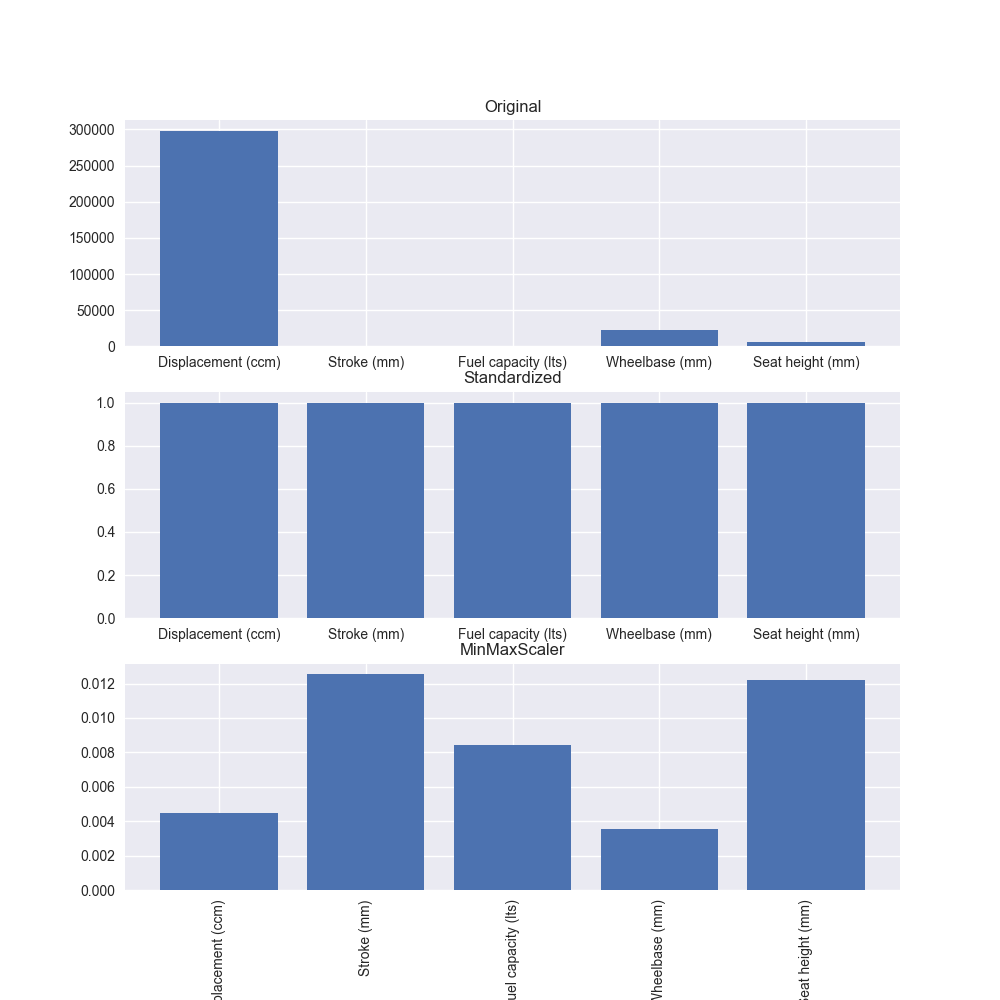

In [30]:
# calculate the variance for numerical columns
numerical_cols_variance_orig = Xworkdf[numerical_cols_name_list].var()

# calculate the variance for numerical columns after standardization
numerical_cols_variance_std = Xworkdf_std[numerical_cols_name_list].var()

# calculate the variance for numerical columns after MinMaxScaler
numerical_cols_variance_mm = Xworkdf_mm[numerical_cols_name_list].var()

# print the variance for numerical columns (formatted to 4 decimal places)

print(f"Original variance:\n{numerical_cols_variance_orig}\n")
print(f"Standardized variance:\n{numerical_cols_variance_std}\n")
print(f"MinMaxScaler variance:\n{numerical_cols_variance_mm}\n")



# For each column, compare the variances before and after standardization and MinMaxScaler
# Plot the variances
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].bar(numerical_cols_variance_orig.index, 
          numerical_cols_variance_orig.values)
ax[0].set_title('Original')
ax[1].bar(numerical_cols_variance_std.index, 
          numerical_cols_variance_std.values)
ax[1].set_title('Standardized')
ax[2].bar(numerical_cols_variance_mm.index, numerical_cols_variance_mm.values)
ax[2].set_title('MinMaxScaler')

plt.xticks(rotation=90)
plt.show()

<b> Full PCA </b>

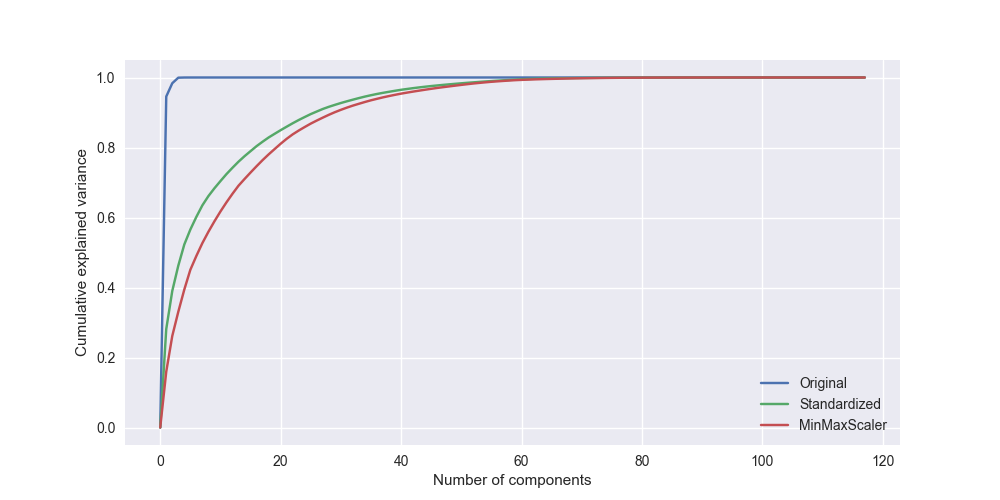

In [31]:
Xworkdf_pca = PCA(svd_solver="full")
Xworkdf_pca.fit(Xworkdf)
exp_var_ratio_orig = np.insert(
    np.cumsum(Xworkdf_pca.explained_variance_ratio_), 0, 0)

Xworkdf_std_pca = PCA(svd_solver="full")
Xworkdf_std_pca.fit(Xworkdf_std)
exp_var_ratio_std = np.insert(
    np.cumsum(Xworkdf_std_pca.explained_variance_ratio_), 0, 0)

Xworkdf_mm_pca = PCA(svd_solver="full")
Xworkdf_mm_pca.fit(Xworkdf_mm)
exp_var_ratio_mm = np.insert(
    np.cumsum(Xworkdf_mm_pca.explained_variance_ratio_), 0, 0)

# Plot the curve of the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(exp_var_ratio_orig, label='Original')
plt.plot(exp_var_ratio_std, label='Standardized')
plt.plot(exp_var_ratio_mm, label='MinMaxScaler')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.show()

As could be see in the above plot, to reach the 35% of the explained variance depending on the scaling method, we need different number of components. As expected, the number of components needed for the min-max scaled data frame is higher than the number of components needed for the standard scaled data frame. This is because MinMaxScaler compresses the data within a smaller range, potentially reducing the spread of values and requiring more components to explain the same percentage of variance. Additionally, MinMaxScaler preserves the distribution shape, including outliers, which can also contribute to the need for more components. The choice of scaling method should consider the data characteristics and analysis objectives.

## Exercise 4


Following what we have done in the previous exercise, we take the minimum number of components needed to reach the 35% of the explained variance for each scaling method and called it $m'$. Then we apply the PCA with number of components equal to $m$ which should be obtained from the following equation:

$$m = min \{m', 5\}$$

The $m$ that we have obtained for each of the scaling methods are as follows: <br>
* Standard Scaler: 2
* Min-Max Scaler: 4

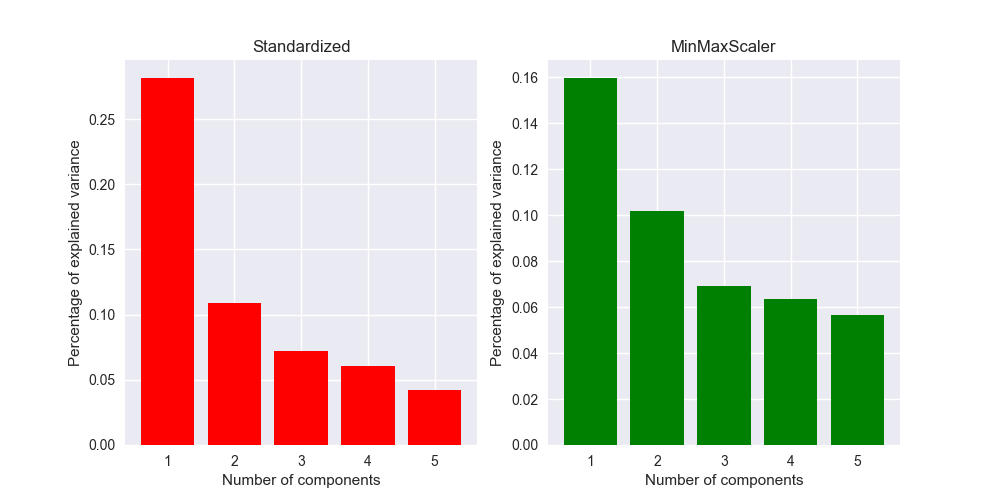

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(np.arange(1, 6), Xworkdf_std_pca.explained_variance_ratio_[:5],
           color='red')
ax[0].set_title('Standardized')
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Percentage of explained variance')
ax[1].bar(np.arange(1, 6), Xworkdf_mm_pca.explained_variance_ratio_[:5],
           color='green')
ax[1].set_title('MinMaxScaler')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Percentage of explained variance')
plt.show()

In [33]:
# Determine the number of principal components for StandardScaler
explained_variance_ratio_std = Xworkdf_std_pca.explained_variance_ratio_
# calculate the cumulative explained variance ratio
cumulative_variance_ratio_std = np.cumsum(explained_variance_ratio_std)
# find the number of components that explain 35% of the variance
num_pcs_std = min(np.argmax(cumulative_variance_ratio_std >= 0.35) + 1, 5)
print(f"Number of principal components for StandardScaler: {num_pcs_std}")

# Determine the number of principal components for MinMaxScaler
explained_variance_ratio_mm = Xworkdf_mm_pca.explained_variance_ratio_
# calculate the cumulative explained variance ratio
cumulative_variance_ratio_mm = np.cumsum(explained_variance_ratio_mm)
# find the number of components that explain 35% of the variance
num_pcs_mm = min(np.argmax(cumulative_variance_ratio_mm >= 0.35) + 1, 5)
print(f"Number of principal components for MinMaxScaler: {num_pcs_mm}")

Number of principal components for StandardScaler: 2
Number of principal components for MinMaxScaler: 4


### Interpretation 

To be able to interpret the obtained principal components, we first need to find the high value positive and negative loadings of each principal component. <br>

To be able to find the high values loads of a principle component, we have to take the following steps: <br>
* After fitting the PCA model, access the `components_` attribute of the model to get the loadings of the principal components. For example `pca.components_[0]` gives the loadings of the first principal component. What we get is an array of loadings for each column (Either positive or negative).
* Then for obtaining the high value loadings, considering the absolute value of the loadings, we sort the array of loadings in descending order and take the first $n$ elements of the array. The indices of these elements are the indices of the columns that have the high value loadings for the corresponding principal component.

PC1:
	Greatest positive loadings: ['Displacement (ccm)', 'Wheelbase (mm)', 'Fuel capacity (lts)', 'Stroke (mm)', 'Engine cylinder_V2', 'Fuel system_injection', 'Front brakes_double disc', 'Engine stroke_four-stroke', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Front brakes_other']
	Greatest negative loadings: ['Engine cylinder_Single cylinder', 'Fuel system_carburettor', 'Front brakes_single disc', 'Engine stroke_two-stroke', 'Fuel control_Not Given/Unknown', 'Seat height (mm)', 'Gearbox_Automatic', 'Cooling system_Air', 'Front brakes_expanding brake (drum brake)', 'Gearbox_Not Given/Unknown']


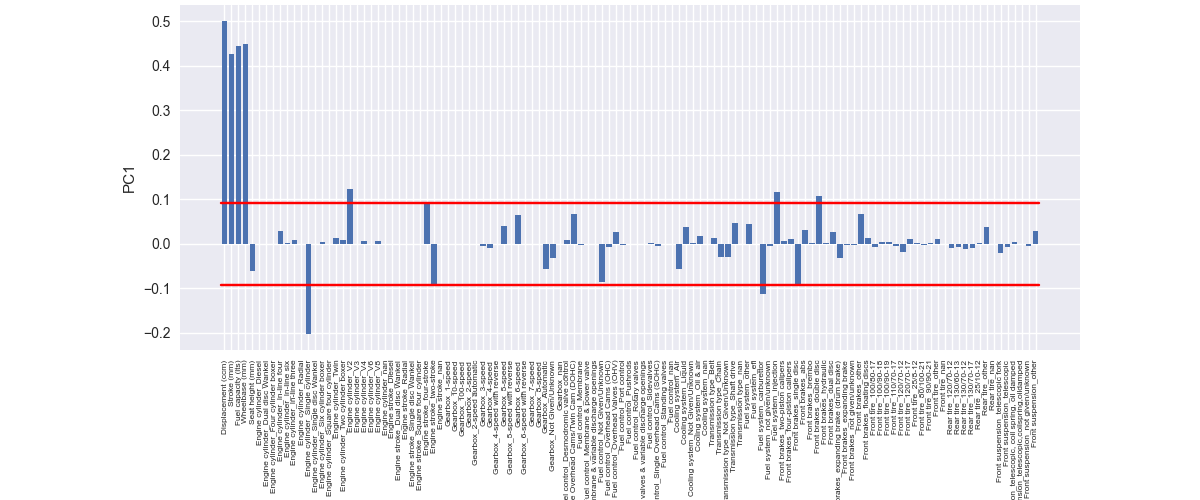

PC2:
	Greatest positive loadings: ['Stroke (mm)', 'Cooling system_Air', 'Front suspension_not given/unknown', 'Front tire_other', 'Transmission type_Belt', 'Fuel control_Not Given/Unknown', 'Engine cylinder_V2', 'Fuel system_carburettor', 'Front brakes_expanding brake (drum brake)', 'Displacement (ccm)']
	Greatest negative loadings: ['Seat height (mm)', 'Cooling system_Liquid', 'Gearbox_6-speed', 'Front suspension_other', 'Transmission type_Chain', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Fuel system_injection', 'Fuel capacity (lts)', 'Front brakes_double disc', 'Front brakes_other']


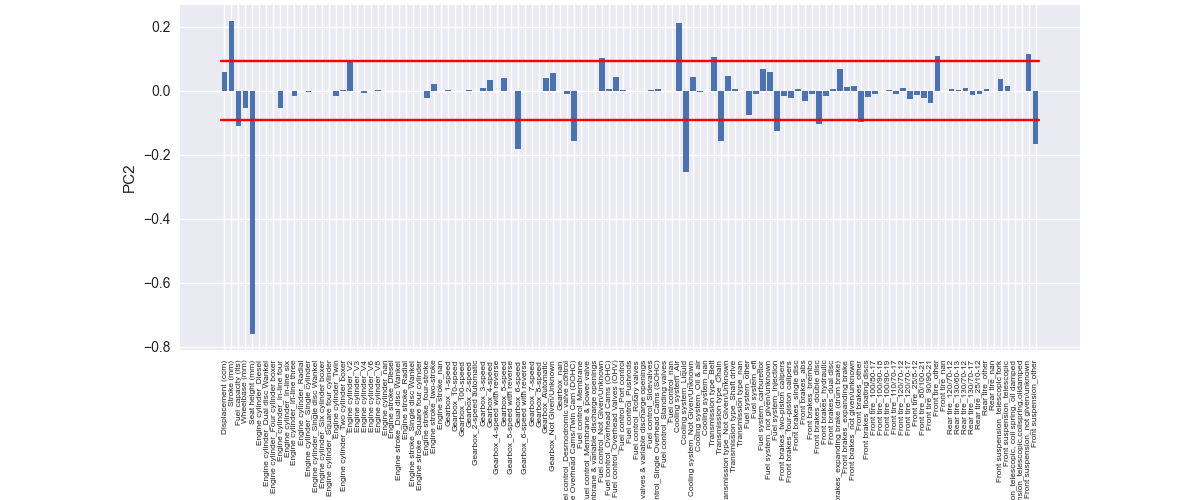

In [34]:
# do pca with the derieved number of PCs
Xworkdf_std_pca = PCA(n_components=num_pcs_std, svd_solver="full")
Xworkdf_std_pca.fit(Xworkdf_std)

eps_std = np.sqrt(1 / Xworkdf_std_pca.n_features_)
for i in range(num_pcs_std):

    ind_great_pos_PCi = np.argsort(
        Xworkdf_std_pca.components_[i, :])[::-1][:10]
    
    ind_great_neg_PCi = np.argsort(
        Xworkdf_std_pca.components_[i, :])[:10]


    great_pos_PCi = [Xworkdf_std.columns[j] for j in ind_great_pos_PCi]
    great_neg_PCi = [Xworkdf_std.columns[j] for j in ind_great_neg_PCi]


    # report the 10 features with the greatest positive and negative loadings for each PC in a table
    print(f"PC{i + 1}:\n\tGreatest positive loadings: {great_pos_PCi}\n"
          f"\tGreatest negative loadings: {great_neg_PCi}")

    # plot with low top plot margin


    plt.figure(figsize=(12, 5))

    # delete the top margin
    plt.subplots_adjust(top=0.99)
    # increase the bottom margin to show the xticks
    plt.subplots_adjust(bottom=0.3)
    # reduce left margin
    plt.subplots_adjust(left=0.15)

    plt.xlabel('Features')
    plt.ylabel('PC' + str(i + 1))
    plt.plot([-.5, Xworkdf_std_pca.n_features_ - .5], 
             [eps_std, eps_std], color='red')
    plt.plot([-.5, Xworkdf_std_pca.n_features_ - .5], 
             [-eps_std, -eps_std], color='red')

    plt.bar(np.arange(Xworkdf_std_pca.n_features_), Xworkdf_std_pca.components_[i, :])
    # xticks much smaller

    plt.xticks(ticks=np.arange(Xworkdf_std_pca.n_features_), 
               labels=Xworkdf.columns.to_list(), rotation=90, fontsize=6)
    plt.show()


<span style="color: blue; font-weight: bold">Interpretation of the obtained principal components for standard scaled data frame:</span> <br>

As could be seen in the above graphs, for PC1, the most important high value positive features are `Displacement (ccm)`, `Wheelbase (mm)`, `Fuel capacity (lts)`, `Stroke (mm)` whereas `Engine cylinder_Single cylinder` is the most important high value negative feature. <br>
Considerig this information, a proper name for PC1 could be `Engine Performance`. <br>
* `Displacement (ccm)` is a measure of the engine's size or volume, which can have a direct impact on its power output. <br>
* `Wheelbase (mm)` and `fuel capacity (lts)` are features that can influence a bike's stability and endurance, both of which are essential  for optimal engine performance. <br> 
* `Stroke (mm)` refers to the distance that the piston travels within the cylinder, which affects power generation.
* `Engine cylinder_Single cylinder` is a feature that indicates the number of cylinders in the engine, which can have a direct impact on its power output.
<br>


For PC2, the most important high value positive features are `Stroke (mm)` and `Cooling system_Air`. The most important high value negative features, however, are `Seat height (mm)` and `Cooling system_Liquid`. <br>Based on this information, a proper name for PC2 could be `Ergonomy and Cooling System`. <br>

Below, the names of the principal components are mentioned: <br>
* PC1: Engine Performance <br>
* PC2: Ergonomy and Cooling System

PC1:
	Greatest positive loadings: ['Fuel system_injection', 'Cooling system_Liquid', 'Front brakes_double disc', 'Front suspension_other', 'Gearbox_6-speed', 'Front brakes_other', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Fuel system_other', 'Engine stroke_four-stroke', 'Engine cylinder_V2']
	Greatest negative loadings: ['Cooling system_Air', 'Front suspension_not given/unknown', 'Engine cylinder_Single cylinder', 'Fuel control_Not Given/Unknown', 'Fuel system_carburettor', 'Fuel system_not given/unknown', 'Front brakes_single disc', 'Engine stroke_two-stroke', 'Gearbox_Not Given/Unknown', 'Transmission type_Not Given/Unknown']


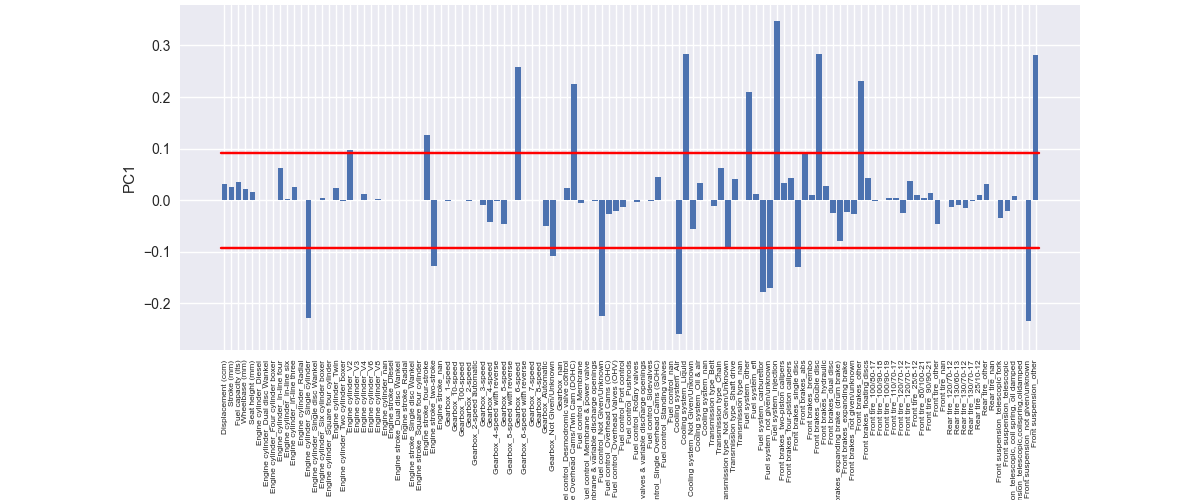

PC2:
	Greatest positive loadings: ['Front suspension_not given/unknown', 'Fuel system_not given/unknown', 'Engine stroke_four-stroke', 'Front brakes_dual disc', 'Engine cylinder_V2', 'Gearbox_5-speed', 'Engine cylinder_In-line four', 'Cooling system_Air', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Rear tire_other']
	Greatest negative loadings: ['Engine cylinder_Single cylinder', 'Fuel system_carburettor', 'Front suspension_other', 'Front brakes_single disc', 'Fuel system_other', 'Engine stroke_two-stroke', 'Fuel control_Not Given/Unknown', 'Gearbox_Automatic', 'Cooling system_Liquid', 'Front brakes_other']


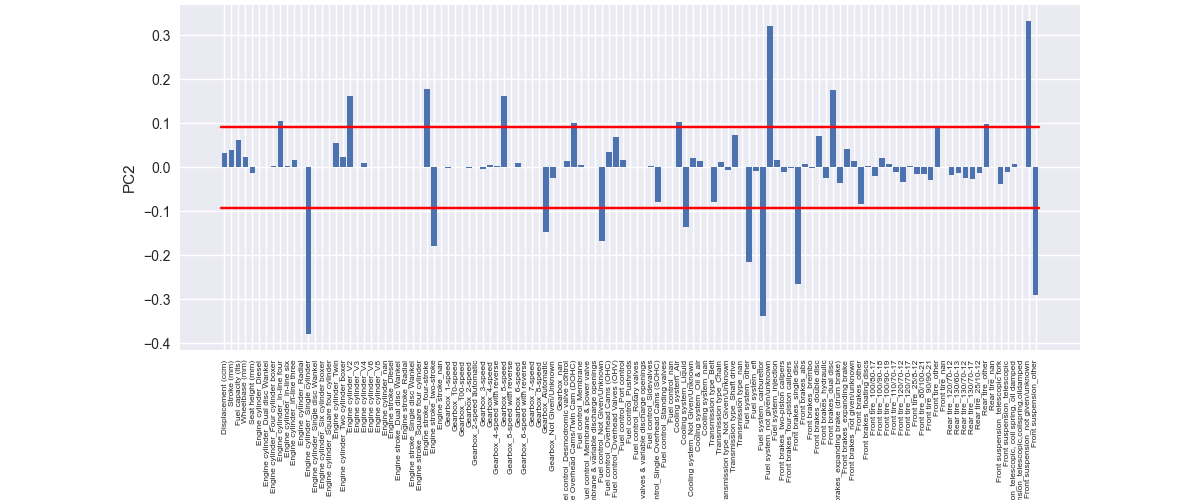

PC3:
	Greatest positive loadings: ['Transmission type_Belt', 'Engine stroke_four-stroke', 'Cooling system_Air', 'Gearbox_Automatic', 'Fuel control_Single Overhead Cams (SOHC)', 'Engine cylinder_V2', 'Fuel system_injection', 'Front suspension_telescopic fork', 'Transmission type_Shaft drive', 'Gearbox_5-speed']
	Greatest negative loadings: ['Transmission type_Chain', 'Gearbox_6-speed', 'Engine stroke_two-stroke', 'Cooling system_Liquid', 'Front suspension_not given/unknown', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Fuel control_Not Given/Unknown', 'Fuel system_not given/unknown', 'Engine cylinder_In-line four', 'Rear tire_other']


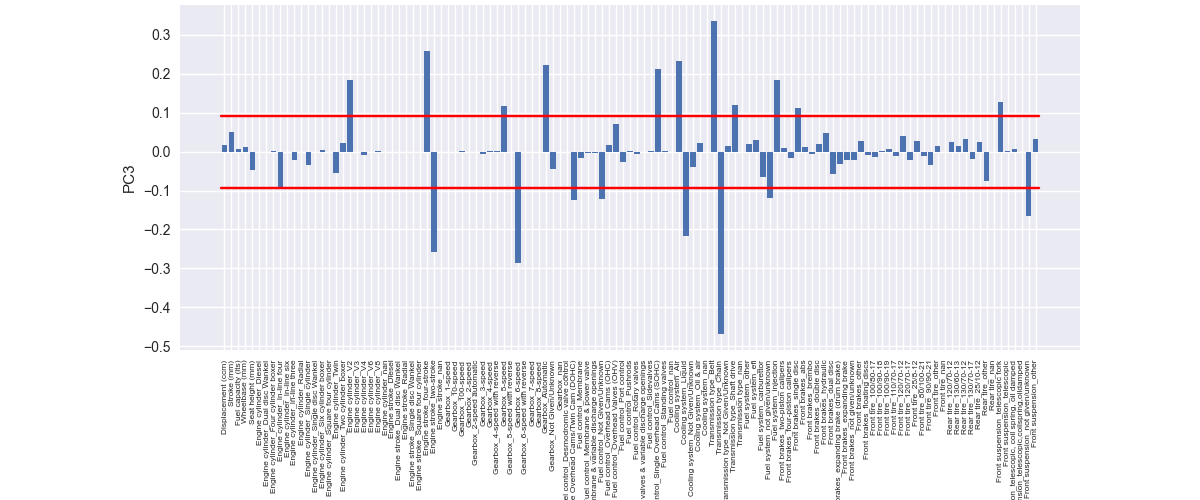

PC4:
	Greatest positive loadings: ['Fuel system_carburettor', 'Cooling system_Air', 'Fuel system_other', 'Transmission type_Chain', 'Front brakes_expanding brake (drum brake)', 'Front tire_other', 'Fuel control_Overhead Valves (OHV)', 'Gearbox_4-speed', 'Rear tire_other', 'Front suspension_other']
	Greatest negative loadings: ['Cooling system_Liquid', 'Front brakes_single disc', 'Fuel system_not given/unknown', 'Gearbox_Automatic', 'Fuel control_Not Given/Unknown', 'Transmission type_Not Given/Unknown', 'Front suspension_not given/unknown', 'Transmission type_Belt', 'Fuel system_injection', 'Engine cylinder_Single cylinder']


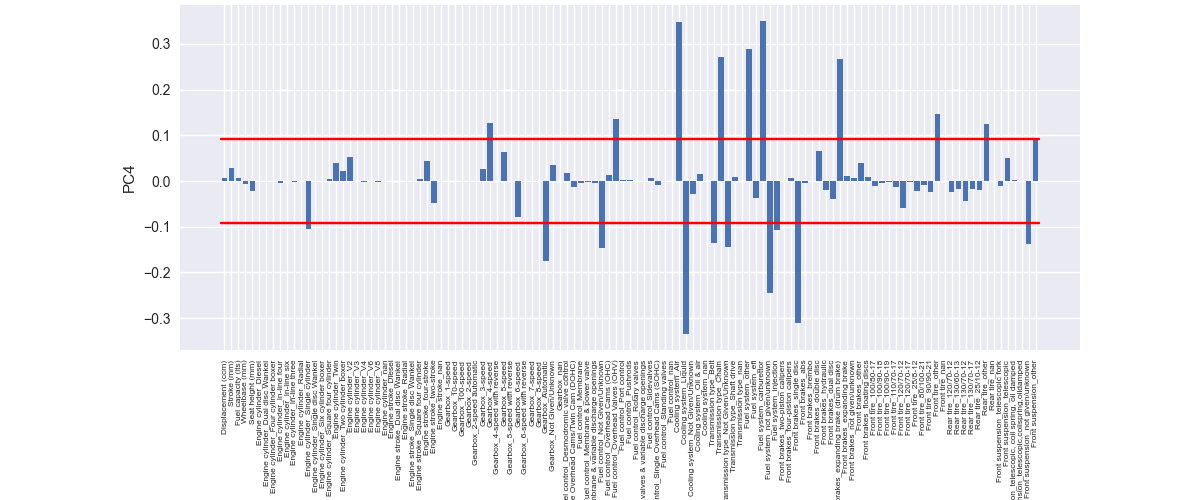

In [35]:
Xworkdf_mm_pca = PCA(n_components=num_pcs_mm, svd_solver="full")
Xworkdf_mm_pca.fit(Xworkdf_mm)

eps_mm = np.sqrt(1 / Xworkdf_mm_pca.n_features_)

for i in range(num_pcs_mm):

    
    # get the indices of the features with the highest values
    ind_great_pos_PCi = np.argsort(Xworkdf_mm_pca.components_[i, :])[::-1][:10]
    ind_great_neg_PCi = np.argsort(Xworkdf_mm_pca.components_[i, :])[:10]

    great_pos_PCi = [Xworkdf_mm.columns[j] for j in ind_great_pos_PCi]
    great_neg_PCi = [Xworkdf_mm.columns[j] for j in ind_great_neg_PCi]


    # report the 10 features with the greatest positive and negative loadings for each PC in a table
    print(f"PC{i + 1}:\n\tGreatest positive loadings: {great_pos_PCi}\n"
          f"\tGreatest negative loadings: {great_neg_PCi}")
    
    plt.figure(figsize=(12, 5))

    # delete the top margin
    plt.subplots_adjust(top=0.99)
    # increase the bottom margin to show the xticks
    plt.subplots_adjust(bottom=0.3)
    # delete left margin
    plt.subplots_adjust(left=0.15)

    plt.xlabel('Features')
    plt.ylabel('PC' + str(i + 1))
    plt.plot([-.5, Xworkdf_mm_pca.n_features_ - .5], 
             [eps_mm, eps_mm], color='red')
    plt.plot([-.5, Xworkdf_mm_pca.n_features_ - .5], 
             [-eps_mm, -eps_mm], color='red')

    plt.bar(np.arange(Xworkdf_mm_pca.n_features_), Xworkdf_mm_pca.components_[i, :])
    # xticks much smaller

    plt.xticks(ticks=np.arange(Xworkdf_mm_pca.n_features_), 
               labels=Xworkdf.columns.to_list(), rotation=90, fontsize=6)
    plt.show()

<span style="color: blue; font-weight: bold">Interpretation of the Obtained Principal Components for Min-Max Scaled Data Frame:</span> <br>

Firstly, it can be observed that due to the type of scaling, the effectiveness of the numerical columns in the principal components is reduced compared to the standard scaled data frame. <br>

For PC1, the most important high-value features are the Fuel system and Cooling system. Specifically, the Injector fuel system and Air/Liquid cooling system are particularly important. <br>
For PC2, the most important high-value features are the Front suspension, Fuel system, and Engine cylinder. Particularly, the Carburetor fuel system and Single cylinder engine are important. <br>
For PC3, the most important high-value features are the Transmission, Engine stroke, and Gearbox. Specifically, the Belt transmission, 4-stroke engine, and 6-speed gearbox are important. <br>
For PC4, the most important high-value features are once again the Fuel System, Front brake, and Cooling system. Particularly, the Carburetor fuel system, Single disk front brake, and Air/Liquid cooling system are important. <br>


Below, the names of the principal components are mentioned:<br>
* PC1: `Fuel Injection(+)-Air(-)/Liq(+) Cooling and Suspension` <br>
* PC2: `Unknown(+)/other(-) Suspension and Fuel System` <br>
* PC3: `Transmission (Belt+ chain-) and Engine Stroke(4+ 2-) and Gearbox(6speed-)` <br>
* PC4: `Carburettor(+) SingleDisk(-) Cool Air(+)Liq(-)` <br>


B) score graph

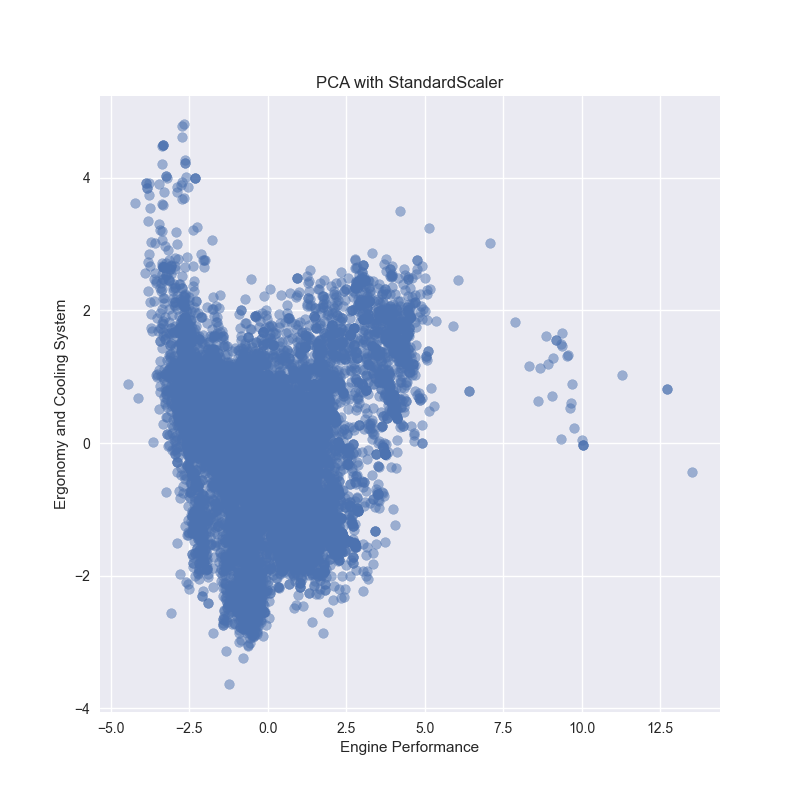

In [36]:
#score graph for PCA_std

Xworkdf_std_transformed = Xworkdf_std_pca.transform(Xworkdf_std)

# convert the transformed data into a dataframe
Xworkdf_std_transformed = pd.DataFrame(Xworkdf_std_transformed,
                                        index=Xworkdf_std.index)


# plot the score graph
plt.figure(figsize=(8, 8))
plt.title('PCA with StandardScaler')
plt.xlabel('Engine Performance')
plt.ylabel('Ergonomy and Cooling System')
plt.scatter(Xworkdf_std_transformed[0], Xworkdf_std_transformed[1],
             alpha=0.5)
plt.show()


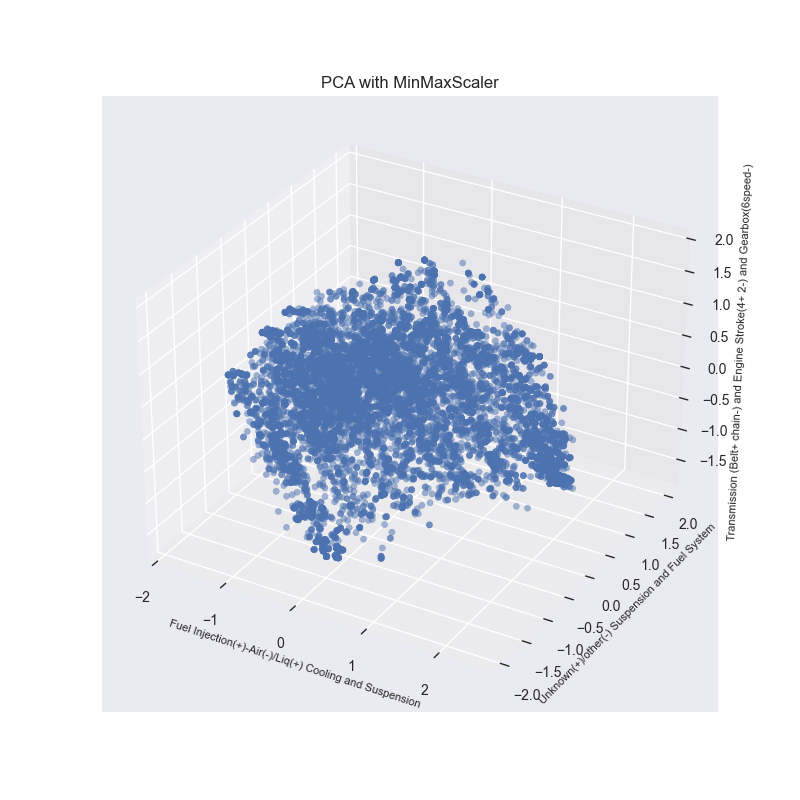

In [37]:
Xworkdf_mm_transformed = Xworkdf_mm_pca.transform(Xworkdf_mm)

# convert yworkdf_std to a dataframe
Xworkdf_mm_transformed = pd.DataFrame(Xworkdf_mm_transformed, 
                                      index=Xworkdf_mm.index)

# plot the score graph in 3d
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PCA with MinMaxScaler')
ax.set_xlabel('Fuel Injection(+)-Air(-)/Liq(+) Cooling and Suspension')
ax.set_ylabel('Unknown(+)/other(-) Suspension and Fuel System')
ax.set_zlabel('Transmission (Belt+ chain-) and Engine Stroke(4+ 2-) and Gearbox(6speed-)')
# set font for labels
ax.xaxis.label.set_fontsize(8)
ax.yaxis.label.set_fontsize(8)
ax.zaxis.label.set_fontsize(8)
# show label in two lines if too long (20 characters)
ax.xaxis.label.set_linespacing(2)

ax.scatter(Xworkdf_mm_transformed[0], Xworkdf_mm_transformed[1],
            Xworkdf_mm_transformed[2], alpha=0.5)
plt.show()

### Exercise 5

For this exercise, we have been asked to apply KMEANS clustering on the data frames and find the optimal K for each of the data frames. To do so, we use the Silhouette Score. The Silhouette Score is a measure of how similar an object is to its own cluster compared to other clusters. <br>

The results suggest that the optimal number of clusters for the standard scaled data frame is $3$, whereas the optimal number of clusters for the min-max scaled data frame is $5$. <br>

The optimal number of clusters is 3


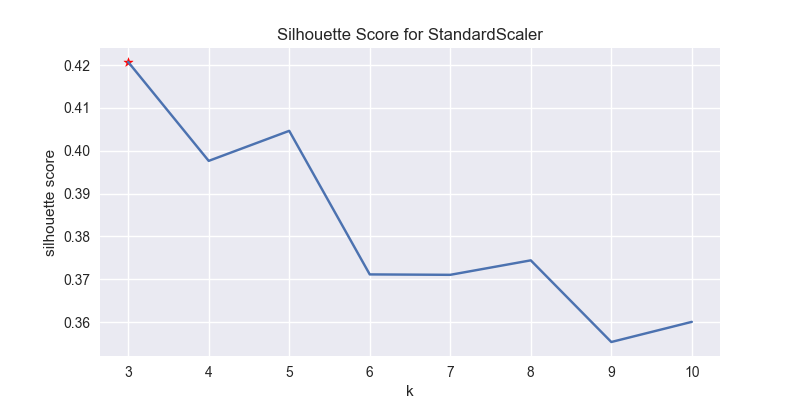

The optimal number of clusters is 5


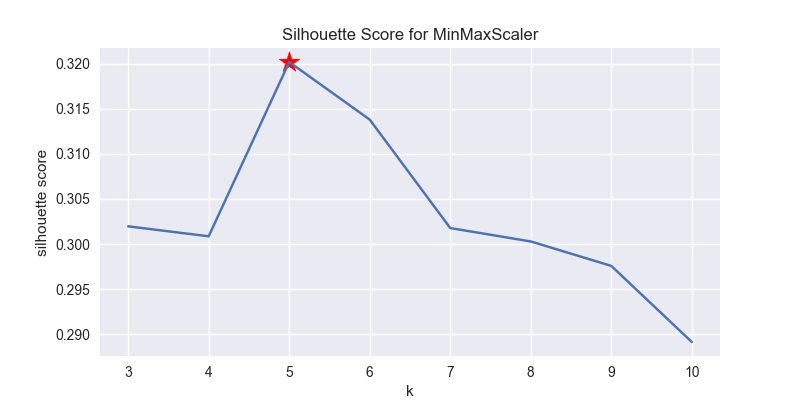

In [38]:
sil_scores_std = []
ks = range(3, 11)

for k in ks:
    # apply kmeans with respect to the PC space (transformed data)
    kmeans_std = KMeans(n_clusters=k, random_state=rs)
    
    kmeans_std.fit(Xworkdf_std_transformed)
    sil_scores_std.append(silhouette_score(Xworkdf_std_transformed,
                                            kmeans_std.labels_))
# find the optimal k
optimal_k_std = ks[sil_scores_std.index(max(sil_scores_std))]
print("The optimal number of clusters is %d" % optimal_k_std)

plt.figure(figsize=(8, 4))
plt.title('Silhouette Score for StandardScaler')
plt.xlabel('k')
plt.ylabel('silhouette score')
# add vertical line for the optimal k
plt.scatter(optimal_k_std, sil_scores_std[optimal_k_std-3],
             marker='*', color='red')
plt.plot(ks, sil_scores_std)
plt.xticks(ks)
plt.show()



sil_scores_mm = []
ks = range(3, 11)
# Xworkdf_mm_transformed.drop("color", axis=1, inplace=True)
for k in ks:
    # apply kmeans with respect to the PC space (transformed data)
    kmeans_mm = KMeans(n_clusters=k, random_state=rs)
    
    kmeans_mm.fit(Xworkdf_mm_transformed)
    sil_scores_mm.append(silhouette_score(Xworkdf_mm_transformed,
                                           kmeans_mm.labels_))
# find the optimal k
optimal_k_mm = ks[sil_scores_mm.index(max(sil_scores_mm))]
print("The optimal number of clusters is %d" % optimal_k_mm)

plt.figure(figsize=(8, 4))
plt.title('Silhouette Score for MinMaxScaler')
plt.xlabel('k')
plt.ylabel('silhouette score')
# add a dot for the optimal k
plt.scatter(optimal_k_mm, sil_scores_mm[optimal_k_mm-3],
             s=250, marker='*', c='r')
plt.plot(ks, sil_scores_mm)
plt.xticks(ks)
plt.show()

## Exercise 6

Using the optimal K(s) that we obtained in the previous exercise, we apply the KMEANS clustering on the data frames and plot the clusters. Then we interpret the centriods of the clusters. <br>

In [39]:
# apply kmeans with the optimal number of clusters
kmeans_std = KMeans(n_clusters=optimal_k_std,
                     random_state=rs)
kmeans_std.fit(Xworkdf_std_transformed)

# get the centroids
centroids_std = kmeans_std.cluster_centers_

# get the cluster labels
labels_std = kmeans_std.labels_
print(centroids_std)


[[-1.62530857  0.43841459]
 [ 0.5859956  -0.7340027 ]
 [ 3.05703612  1.17753473]]


In [40]:
kmeans_mm = KMeans(n_clusters=optimal_k_mm,
                    random_state=rs)
kmeans_mm.fit(Xworkdf_mm_transformed)

# get the centroids
centroids_mm = kmeans_mm.cluster_centers_

# get the cluster labels
labels_mm = kmeans_mm.labels_
print(centroids_mm)


[[-0.70003253 -0.29321037 -0.01677979  0.82565682]
 [ 1.4957634   0.14518447  0.04428806  0.05438064]
 [ 0.02864584 -1.0681588  -0.77844636 -0.30191231]
 [-0.38140574 -0.48593678  0.74616465 -0.49384219]
 [-0.67386089  1.09232385 -0.24882215 -0.27548177]]


Having obtained the centroids of the clusters, we can interpret the clusters as follows: <br>
* Find the nearest point to the centroid of each cluster. <br>
* Find the index of the nearest point.<br>
* Find the corresponding row in the scaled data frame.<br>
* Obtain the original values using the inverse transform method.<br>
* Interpret the cluster.

In [41]:
centroids_we_want_mm={}

for i, point in enumerate(centroids_mm):
    # calculate the distance between each point and the centroid
    Xworkdf_mm_transformed[f"Centroid{i}"] = np.sqrt(
        (Xworkdf_mm_transformed[0] - (point[0]))**2 + (Xworkdf_mm_transformed[1] - point[1])**2)
    
    # get the index of the point that is closest to the centroid
    centroids_we_want=Xworkdf_mm_transformed.loc[
        Xworkdf_mm_transformed[f"Centroid{i}"] == Xworkdf_mm_transformed[f"Centroid{i}"].min()]
    
    # get the row of the point
    row=Xworkdf_mm.loc[centroids_we_want.index.values[0],:]

    # convert the row to a dataframe
    row=pd.DataFrame(row.values.reshape(1,-1),columns=Xworkdf_mm.columns)

    # inverse transform the row
    row[numerical_cols_name_list] = mm_scaler.inverse_transform(
        row[numerical_cols_name_list])
    
    centroids_we_want_mm[i]=row    


In [42]:
centroids_we_want_std={}

for i, point in enumerate(centroids_std):
    # calculate the distance between each point and the centroid
    Xworkdf_std_transformed[f"Centroid{i}"] = np.sqrt(
        (Xworkdf_std_transformed[0] - (point[0]))**2 + (Xworkdf_std_transformed[1] - point[1])**2)
    
    # get the index of the point that is closest to the centroid
    centroids_we_want=Xworkdf_std_transformed.loc[
        Xworkdf_std_transformed[f"Centroid{i}"] == Xworkdf_std_transformed[f"Centroid{i}"].min()]
    
    # get the row of the point
    row=Xworkdf_std.loc[centroids_we_want.index.values[0],:]
    
    # convert the row to a dataframe
    row=pd.DataFrame(row.values.reshape(1,-1),columns=Xworkdf_std.columns)
    
    # inverse transform the row
    row[numerical_cols_name_list] = scaler_std.inverse_transform(
        row[numerical_cols_name_list])
    
    centroids_we_want_std[i]=row


In [43]:
#turning the dictionary into a dataframe
centroids_we_want_std_df = pd.DataFrame()
for k,v in centroids_we_want_std.items():
    # make dataframe
    centroids_we_want_std_df = pd.concat(
        [centroids_we_want_std_df, v], axis=0)


centroids_we_want_mm_df = pd.DataFrame()
for k,v in centroids_we_want_mm.items():
    # make dataframe
    centroids_we_want_mm_df=pd.concat([centroids_we_want_mm_df, v], axis=0)


In [44]:
#finding the columns which start with cooling system   
cooling_system_cols = [col for col in centroids_we_want_std_df.columns 
                       if col.startswith('Cooling system')]

# create a dataframe with the new columns
centroids_we_want_std_df[cooling_system_cols]

,Cooling system_Air,Cooling system_Liquid,Cooling system_Not Given/Unknown,Cooling system_Oil & air,Cooling system_nan
0,False,False,True,False,False
0,True,False,False,False,False
0,False,True,False,False,False


In [45]:
#finding the columns which start with cooling system   
cooling_system_cols = [col for col in centroids_we_want_mm_df.columns 
                       if col.startswith('Cooling system')]

# create a dataframe with the new columns
centroids_we_want_mm_df[cooling_system_cols]

,Cooling system_Air,Cooling system_Liquid,Cooling system_Not Given/Unknown,Cooling system_Oil & air,Cooling system_nan
0,False,True,False,False,False
0,False,True,False,False,False
0,True,False,False,False,False
0,True,False,False,False,False
0,True,False,False,False,False


In [46]:
#finding the columns which start with Engine cylinder  
cooling_system_cols = [col for col in centroids_we_want_mm_df.columns 
                       if col.startswith('Engine cylinder')]

# create a dataframe with the new columns
centroids_we_want_mm_df[cooling_system_cols]

,Engine cylinder_Diesel,Engine cylinder_Dual disc Wankel,Engine cylinder_Four cylinder boxer,Engine cylinder_In-line four,Engine cylinder_In-line six,Engine cylinder_In-line three,Engine cylinder_Radial,Engine cylinder_Single cylinder,Engine cylinder_Single disc Wankel,Engine cylinder_Six cylinder boxer,Engine cylinder_Square four cylinder,Engine cylinder_Twin,Engine cylinder_Two cylinder boxer,Engine cylinder_V2,Engine cylinder_V3,Engine cylinder_V4,Engine cylinder_V6,Engine cylinder_V8,Engine cylinder_nan
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [47]:
#finding the columns which start with Fuel system   
cooling_system_cols = [col for col in centroids_we_want_mm_df.columns 
                       if col.startswith('Fuel system')]

# create a dataframe with the new columns
centroids_we_want_mm_df[cooling_system_cols]

,Fuel system_other,Fuel system_efi,Fuel system_carburettor,Fuel system_not given/unknown,Fuel system_injection
0,0,0,1,0,0
0,1,0,0,0,1
0,1,0,1,0,0
0,1,0,1,0,0
0,0,0,0,1,0


In [48]:
#finding the columns which start with Transmission type
cooling_system_cols = [col for col in centroids_we_want_mm_df.columns 
                       if col.startswith('Transmission type')]

# create a dataframe with the new columns
centroids_we_want_mm_df[cooling_system_cols]

,Transmission type_Belt,Transmission type_Chain,Transmission type_Not Given/Unknown,Transmission type_Shaft drive,Transmission type_nan
0,False,True,False,False,False
0,True,False,False,False,False
0,False,True,False,False,False
0,False,True,False,False,False
0,False,True,False,False,False


In [49]:
#finding the columns which start with Engine stroke
cooling_system_cols = [col for col in centroids_we_want_mm_df.columns 
                       if col.startswith('Engine stroke')]

# create a dataframe with the new columns
centroids_we_want_mm_df[cooling_system_cols]

,Engine stroke_Diesel,Engine stroke_Dual disc Wankel,Engine stroke_Radial,Engine stroke_Single disc Wankel,Engine stroke_Square four cylinder,Engine stroke_four-stroke,Engine stroke_two-stroke,Engine stroke_nan
0,False,False,False,False,False,True,False,False
0,False,False,False,False,False,True,False,False
0,False,False,False,False,False,True,False,False
0,False,False,False,False,False,True,False,False
0,False,False,False,False,False,False,True,False


Considering the above data, we can give the following names to the clusters: </br>
* Cluster 1 std = `LowDisplacement` </br>
* Cluster 2 std = `MidDisplacement_CoolingAir` </br>
* Cluster 3 std = `HighDisplacement_HighSeatHeight` </br>
<br>
* Cluster 1 mm = `LiquidCoolingSystem_Carburettor`</br>
* Cluster 2 mm = `LiquidCoolingSystem_V2EngineCylinder_Injection`</br>
* Cluster 3 mm = `AirCoolingSystem_Carburettor`</br>
* Cluster 4 mm = `SingleCylinder_FuelSystemOther` 		</br>
* Cluster 5 mm = `FuelSystemNotGiven_EngineCylinderIn_LineThree` </br>

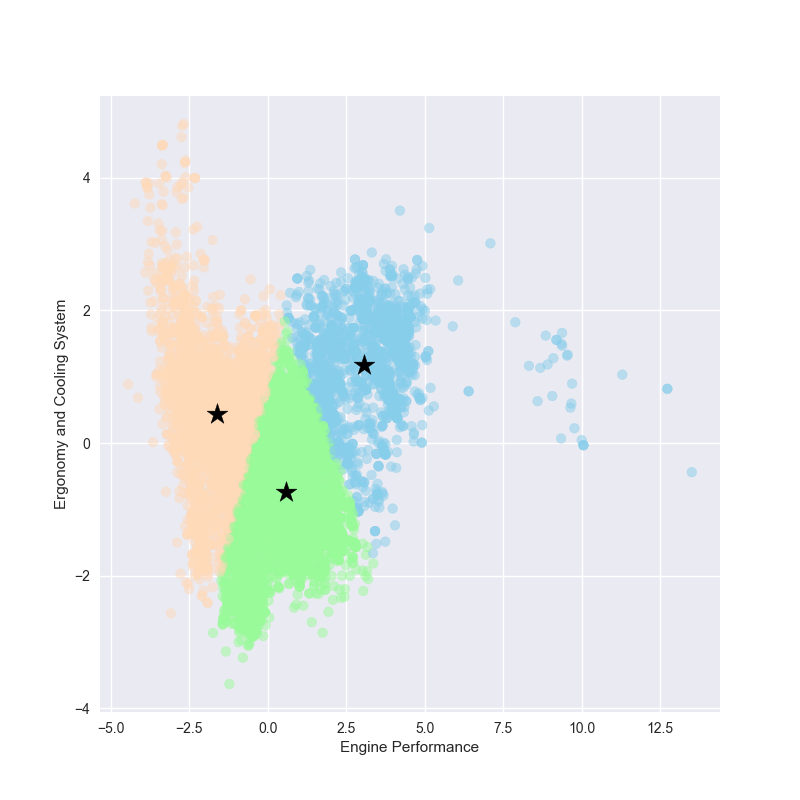

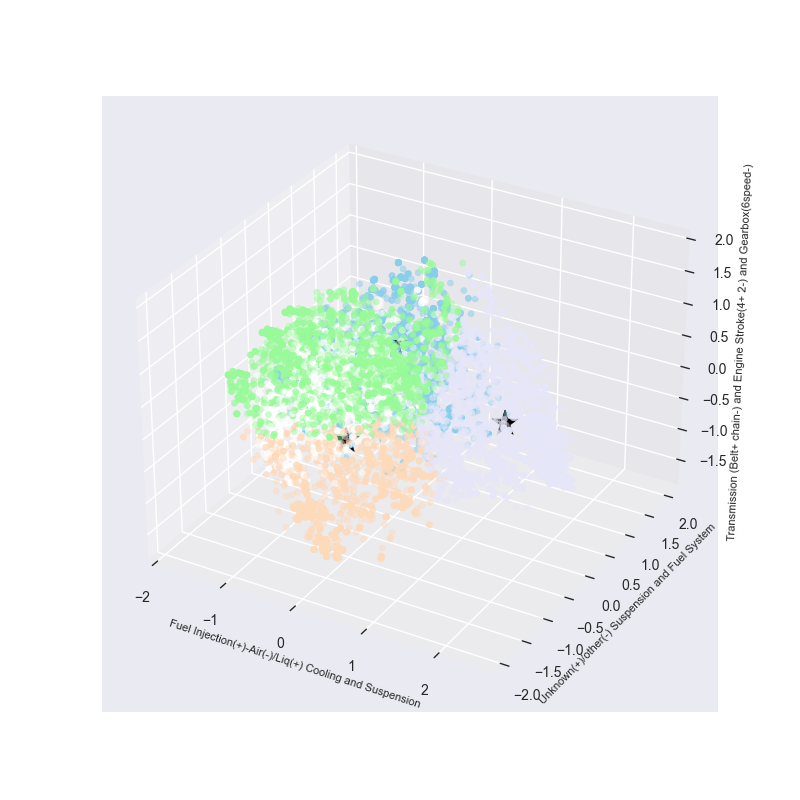

In [50]:
#plot for MinMaxScaler
#make colors based on kmeans labels (sexy colors)
colors = ['#FFDAB9', '#98FB98', '#87CEEB']
#plot the data
plt.figure(figsize=(8, 8))
plt.scatter(Xworkdf_std_transformed[0], Xworkdf_std_transformed[1],
             c=[colors[i] for i in labels_std], alpha=0.5)
#plot the centroids
plt.scatter(centroids_std[:, 0], centroids_std[:, 1], marker='*', c='black', s=250)
plt.xlabel('Engine Performance')
plt.ylabel('Ergonomy and Cooling System')
plt.show()


#plot for MinMaxScaler
#make colors based on kmeans labels
colors = ['#FFFFFF', '#E6E6FA', '#FFDAB9', '#98FB98', '#87CEEB']

#plot the data 3d
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xworkdf_mm_transformed[0], Xworkdf_mm_transformed[1],
            Xworkdf_mm_transformed[2], c=[colors[i] for i in labels_mm], alpha=0.5)
#plot the centroids
plt.scatter(centroids_mm[:, 0], centroids_mm[:, 1], marker='*', c='black', s=400,alpha=1)
ax.set_xlabel('Fuel Injection(+)-Air(-)/Liq(+) Cooling and Suspension')
ax.set_ylabel('Unknown(+)/other(-) Suspension and Fuel System')
ax.set_zlabel('Transmission (Belt+ chain-) and Engine Stroke(4+ 2-) and Gearbox(6speed-)')

# lower axis label font size
ax.xaxis.label.set_size(8)
ax.yaxis.label.set_size(8)
ax.zaxis.label.set_size(8)
plt.show()

## Exercise 7

**Intenal Evaluation (Silhouette Score)**

In [51]:
# compute silhouette score
silhouette_score(Xworkdf_mm_transformed, labels_mm)
print(f"Silhouette score for MinMaxScaler:{silhouette_score(Xworkdf_mm_transformed, labels_mm)}")
# compute silhouette score
silhouette_score(Xworkdf_std_transformed, labels_std)
print(f"Silhouette score for StandardScaler: {silhouette_score(Xworkdf_std_transformed, labels_std)}")

Silhouette score for MinMaxScaler:0.3146953225824264
Silhouette score for StandardScaler: 0.430878178986913


**External Evaluation:**
1. Calinski-Harabasz index (also known as the Variance Ratio Criterion):
The Calinski-Harabasz index is a measure of cluster separation and compactness. It calculates the ratio of the between-cluster dispersion to the within-cluster dispersion. Mathematically, it is defined as:<br>

$$
\text{{Calinski-Harabasz Index}} = \frac{{\text{{Between-Cluster Dispersion}}}}{{\text{{Within-Cluster Dispersion}}}} \times \frac{{N - k}}{{k - 1}}
$$

where: <br>
- $\text{{Between-Cluster Dispersion}}$ measures the dispersion between different clusters and is based on the distances between cluster centroids.
- $\text{{Within-Cluster Dispersion}}$ measures the dispersion within each cluster and is based on the distances between data points within the same cluster.
- $N$ is the total number of data points.
- $k$ is the number of clusters.
<br>
A higher Calinski-Harabasz index indicates better-defined and more separated clusters. <br>

2. Davies-Bouldin index:
The Davies-Bouldin index is a measure of cluster quality and separation. It calculates the average similarity between clusters based on the distances between cluster centroids. Mathematically, it is defined as: <br>

$$
\text{{Davies-Bouldin Index}} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{{\text{{Within-Cluster Dispersion}}(i) + \text{{Within-Cluster Dispersion}}(j)}}{{\text{{Distance}}(C_i, C_j)}} \right)
$$
    
where:
- $k$ is the number of clusters.
- $\text{{Within-Cluster Dispersion}}(i)$ measures the dispersion within cluster $i$ and is based on the distances between data points within the same cluster.
- $C_i$ and $C_j$ are the centroids of clusters $i$ and $j$ respectively.
- $\text{{Distance}}(C_i, C_j)$ is a measure of dissimilarity between cluster centroids.

A lower Davies-Bouldin index indicates better separation and more distinct clusters.
<br>
These indices provide quantitative measures to evaluate the quality and separation of clusters obtained from a clustering algorithm. Higher values of the Calinski-Harabasz index and lower values of the Davies-Bouldin index indicate better clustering performance.

In [52]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Compute Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(Xworkdf_mm_transformed, labels_mm)
print(f"Calinski-Harabasz index for MinMaxScaler: {calinski_harabasz}")

# Compute Davies-Bouldin index
davies_bouldin = davies_bouldin_score(Xworkdf_mm_transformed, labels_mm)
print(f"Davies-Bouldin index for MinMaxScaler: {davies_bouldin}")

# Compute Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(Xworkdf_std_transformed, labels_std)
print(f"Calinski-Harabasz index for StandardScaler: {calinski_harabasz}")

# Compute Davies-Bouldin index
davies_bouldin = davies_bouldin_score(Xworkdf_std_transformed, labels_std)
print(f"Davies-Bouldin index for StandardScaler: {davies_bouldin}")



Calinski-Harabasz index for MinMaxScaler: 5756.987792420724
Davies-Bouldin index for MinMaxScaler: 1.3248431551004025
Calinski-Harabasz index for StandardScaler: 10849.269766762685
Davies-Bouldin index for StandardScaler: 0.8369383982499347
